In [267]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import xgboost as xg

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE

import pandas as pd
import numpy as np
import pdb
import matplotlib.pyplot as plt
import seaborn as sns

import optuna

In [268]:
df = pd.read_csv("data.csv", parse_dates=["date"], index_col="date")
df.sort_index(inplace=True)
df = df.dropna()
df.describe()

,DGS1,DGS10,DGS1MO,DGS2,DGS30,DGS3MO,DGS5
count,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000
mean,1.487239,3.024253,1.193482,1.719596,3.695501,1.258955,2.374225
std,1.487760,1.183471,1.444925,1.420544,1.136323,1.474201,1.278228
min,0.040000,0.520000,0.000000,0.090000,0.990000,0.000000,0.190000
25%,0.210000,2.050000,0.060000,0.520000,2.870000,0.090000,1.410000
50%,1.110000,2.860000,0.550000,1.330000,3.590000,0.800000,2.110000
75%,2.290000,4.080000,1.850000,2.610000,4.690000,1.920000,3.270000
max,5.300000,5.440000,5.270000,5.290000,5.920000,5.190000,5.230000


In [269]:
def gen_diff_df(df, lags=[]):
    df = df.copy()

    for lag in lags:
        col, lag_market_days = lag.split("_")
        lag_market_days = int(lag_market_days)
        df[f"{col}_lag_{lag_market_days}"] = df[col] - df[col].shift(lag_market_days)

    return df.dropna()

# example
lags = ["DGS10_5"]
# gen_diff_df(df, lags=lags)

In [270]:
SPLIT_DATE_STR = '06-01-2020'

def run_ml(df, params):
    lags = params.get("lags")
    predict_lead_days = params.get("predict_lead_days")
    boosting_rounds = params.get("boosting_rounds")
    
    df = gen_diff_df(df, lags=lags)

    # generate the target variable in the future X rows
    target_col = "DGS10"
    df["target"] = df[target_col].shift(-predict_lead_days)
    cols = df.columns.tolist()
    cols.remove("target")
    input_columns = cols.copy()

    train = df.loc[df.index < SPLIT_DATE_STR].dropna()
    test = df.loc[df.index >= SPLIT_DATE_STR].dropna()

    def gen_xy(df, input_columns):
        xdf = df.copy()
        x = xdf[input_columns].copy()
        y = xdf['target']
        return (x,y)
    
    x_train, y_train = gen_xy(train, input_columns)
    x_test, y_test = gen_xy(test, input_columns)

    train_dmatrix = xg.DMatrix(data=x_train, label=y_train)
    test_dmatrix = xg.DMatrix(data=x_test, label=y_test)
    
    # Parameter dictionary specifying base learner
    param = {
        "booster": "gblinear", 
        "objective": "reg:squarederror"
    }
    xgb_r = xg.train(params=param, dtrain=train_dmatrix, num_boost_round=boosting_rounds)
    test['predict'] = xgb_r.predict(test_dmatrix)

    results = {}
    
    rmse = np.sqrt(MSE(y_test, test['predict']))
    results["rmse"] = rmse
    
    mae = mean_absolute_error(y_pred=test['predict'], y_true=y_test)
    results["mae"] = mae
    
    results["model"] = xgb_r
    results["test"] = test
    results["train"] = train

    return results

# lags = ["DGS10_5"]
# run_ml(df, lags=lags, predict_lead_days=10)

In [271]:
def objective(trial):
    predict_lead_days = trial.suggest_int('predict_lead_days', 10, 30)
    boosting_rounds = trial.suggest_int('boosting_rounds', 20, 100)

    lags = []
    params = {
        "predict_lead_days": predict_lead_days,
        "boosting_rounds": boosting_rounds,
        "lags": lags,
    }
    results = run_ml(df, params)
    
    return results['rmse'], results['mae']

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(directions=['minimize', 'minimize'])
study.optimize(objective, n_trials=100)

study.best_trials

[FrozenTrial(number=22, values=[0.20599919282118465, 0.15308077035156198], datetime_start=datetime.datetime(2022, 11, 8, 20, 28, 53, 488565), datetime_complete=datetime.datetime(2022, 11, 8, 20, 28, 53, 603488), params={'predict_lead_days': 10, 'boosting_rounds': 61}, distributions={'predict_lead_days': IntDistribution(high=30, log=False, low=10, step=1), 'boosting_rounds': IntDistribution(high=100, log=False, low=20, step=1)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=22, state=TrialState.COMPLETE, value=None)]

0.03819051931922096 0.14802919396530353


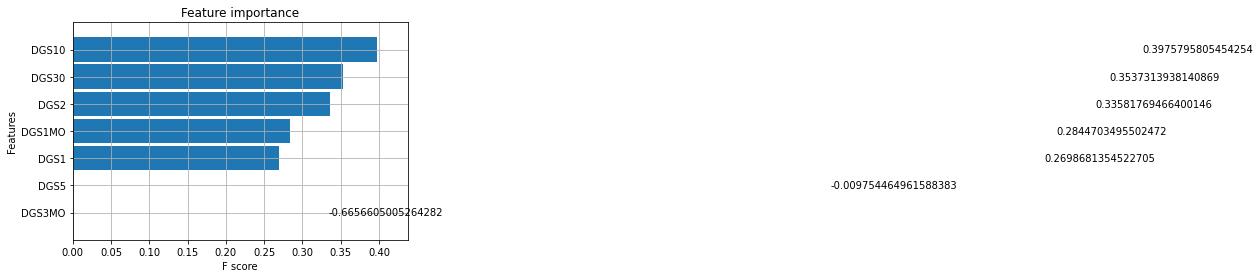

In [272]:
params = study.best_trials[0].params
params['lags'] = [] # ["DGS10_5", "DGS1_3", "DGS5_3"]
result = run_ml(df, params)

mse = mean_squared_error(y_true=result['test']['target'],
                   y_pred=result['test']['predict'])

mae = mean_absolute_error(y_true=result['test']['target'],
                   y_pred=result['test']['predict'])

print(mse, mae)

_ = plot_importance(result["model"], height=0.9)

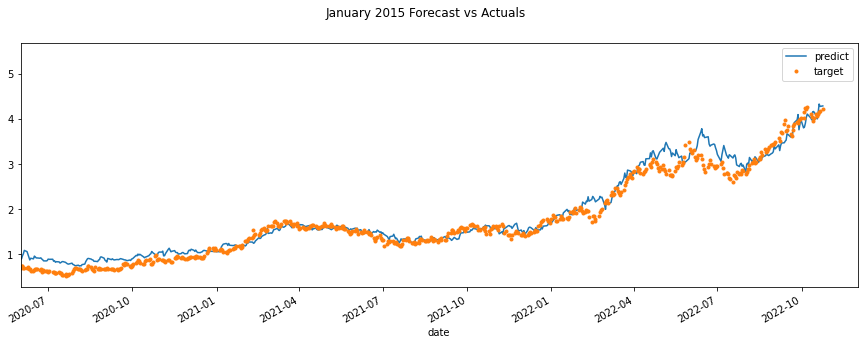

In [273]:
data_all = pd.concat([result['test'], result['train']], sort=False)

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax = data_all[['predict', 'target']].plot(ax=ax, style=['-','.'])

ax.set_xbound(lower=SPLIT_DATE_STR, upper='12-01-2022')
plot = plt.suptitle('January 2015 Forecast vs Actuals')


In [274]:
data_all

,DGS1,DGS10,DGS1MO,DGS2,DGS30,DGS3MO,DGS5,target,predict
date,,,,,,,,,
2020-06-01,0.17,0.66,0.12,0.14,1.46,0.14,0.31,0.71,0.888784
2020-06-02,0.17,0.68,0.12,0.17,1.48,0.15,0.32,0.75,0.907131
2020-06-03,0.17,0.77,0.12,0.19,1.56,0.16,0.38,0.74,0.970686
2020-06-04,0.17,0.82,0.13,0.19,1.61,0.15,0.40,0.71,1.017557
2020-06-05,0.18,0.91,0.13,0.22,1.68,0.15,0.47,0.70,1.090191
...,...,...,...,...,...,...,...,...,...
2020-05-22,0.17,0.66,0.09,0.17,1.37,0.12,0.34,0.88,NaN
2020-05-26,0.17,0.69,0.10,0.18,1.43,0.14,0.35,0.84,NaN
2020-05-27,0.18,0.68,0.11,0.19,1.44,0.15,0.34,0.75,NaN


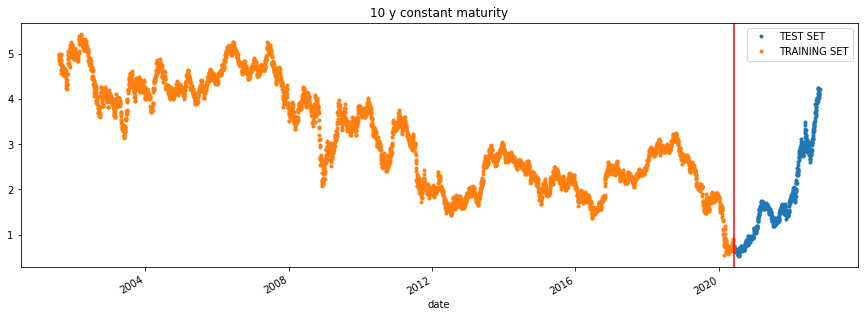

In [275]:
xplot = (
    result['test'][['target']]
    .rename(columns={'target': 'TEST SET'})
    .join(result['train'][['target']].rename(columns={'target': 'TRAINING SET'}), how='outer')
    .plot(figsize=(15,5), title='10 y constant maturity', style='.')
)

plt.axvline(SPLIT_DATE_STR, color='red')

In [276]:
# test['predict'] = reg.predict(X_test)


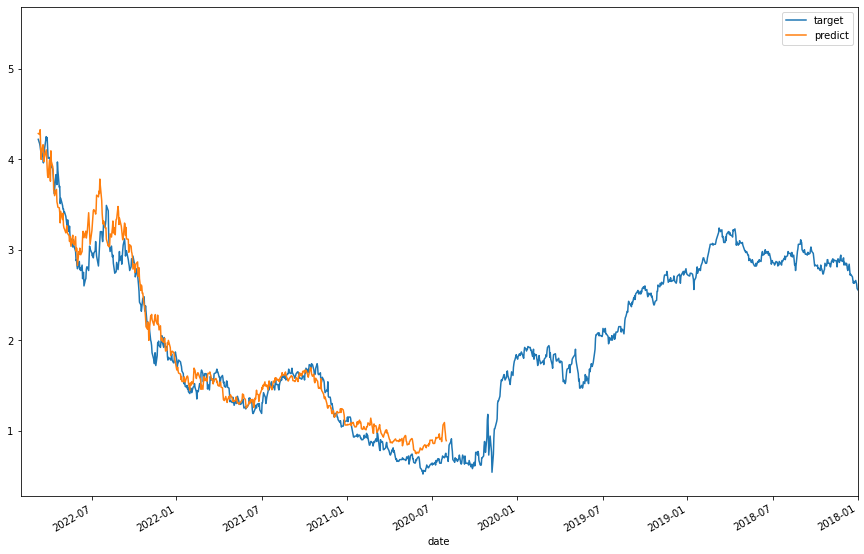

In [278]:
data_all = pd.concat([result['test'], result['train']], sort=False)
ax = data_all[['target','predict']].plot(figsize=(15, 10))
ax.set_xbound(lower='2018-1-1', upper='12-01-2022')

In [279]:
df

,DGS1,DGS10,DGS1MO,DGS2,DGS30,DGS3MO,DGS5
date,,,,,,,
2001-07-31,3.53,5.07,3.67,3.79,5.51,3.54,4.57
2001-08-01,3.56,5.11,3.65,3.83,5.53,3.53,4.62
2001-08-02,3.57,5.17,3.65,3.89,5.57,3.53,4.69
2001-08-03,3.57,5.20,3.63,3.91,5.59,3.52,4.72
2001-08-06,3.56,5.19,3.62,3.88,5.59,3.52,4.71
...,...,...,...,...,...,...,...
2022-11-01,4.75,4.07,3.72,4.54,4.14,4.23,4.27
2022-11-02,4.76,4.10,3.70,4.61,4.15,4.22,4.30
2022-11-03,4.78,4.14,3.75,4.71,4.18,4.25,4.36
